In [1]:
!pip install sklearn
!pip install pandas
!pip install statsmodels
!pip install seaborn

     |████████████████████████████████| 6.7MB 2.0MB/s eta 0:00:01     |█████████████████████████▌      | 5.3MB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 286kB 26.1MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 10.5MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 512kB 25.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 8.1MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 235kB 52.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 215kB 2.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import datetime as dt
import math
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

## Split data
- Merge labels and features into one table
- Split data from each city
- Split train and validation tables


In [3]:
train_split_size = 0.75

labels = pd.read_csv('../data/dengue_labels_train.csv')
features = pd.read_csv('../data/dengue_features_train.csv')
df = labels.merge(features)

sj_data = df[df.city == 'sj']
iq_data = df[df.city == 'iq']

sj_data = sj_data.reset_index()
iq_data = iq_data.reset_index()


def split(df, train_split_size):
    train_size = int(math.ceil(len(df)*train_split_size))
    val_size = int(math.floor((len(df)*(1-train_split_size))))
    return df[0:train_size], df[train_size:train_size+val_size]


sj_train, sj_val = split(sj_data, train_split_size)
iq_train, iq_val = split(iq_data, train_split_size)

# Random Baseline

In [4]:
def random_baseline(train_data, val_data):
    Y = train_data['total_cases'].values
    ymean = np.mean(Y)
    ystd = np.std(Y)
    print("Mean = {}".format(ymean))
    
    Y_val = val_data['total_cases'].values
    Y_pred = np.random.normal(ymean, ystd, len(Y_val))
    
    error = mean_absolute_error(Y_val, Y_pred)
    print("Validation MAE = {}".format(error))
    
random_baseline(sj_train, sj_val)
random_baseline(iq_train, iq_val)
    

Mean = 38.00854700854701
Validation MAE = 52.425838589925846
Mean = 6.630769230769231
Validation MAE = 11.70654963411831


# Model as a Regression

In [5]:
def treat_features(data):
    Y = data['total_cases'].values.reshape(-1, 1)
    data = data.drop(['index', 'total_cases', 'city', 'year', 'week_start_date', 'weekofyear'], axis=1)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    X = (data - data.mean()) / (data.max() - data.min())
    X = X.values
    return X, Y


def feature_regression(train_data, val_data):

    linear_regressor = LinearRegression()  # create object for the class

    X, Y = treat_features(train_data)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    print("Train MAE = {}".format(error))


    X, Y = treat_features(val_data)  # values converts it into a numpy array
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    print("Validation MAE = {}".format(error))
    
    
feature_regression(sj_train, sj_val)
feature_regression(iq_train, iq_val)

Train MAE = 31.98444408167357
Validation MAE = 29.823997020174605
Train MAE = 5.40114382993373
Validation MAE = 8.06027711034363


# Temporal Regression

200.0


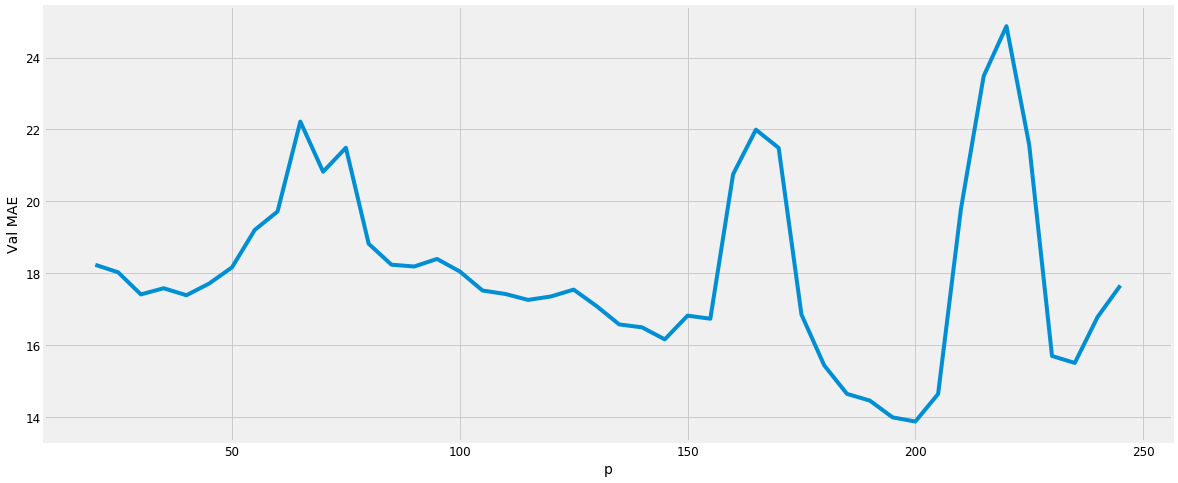

95.0


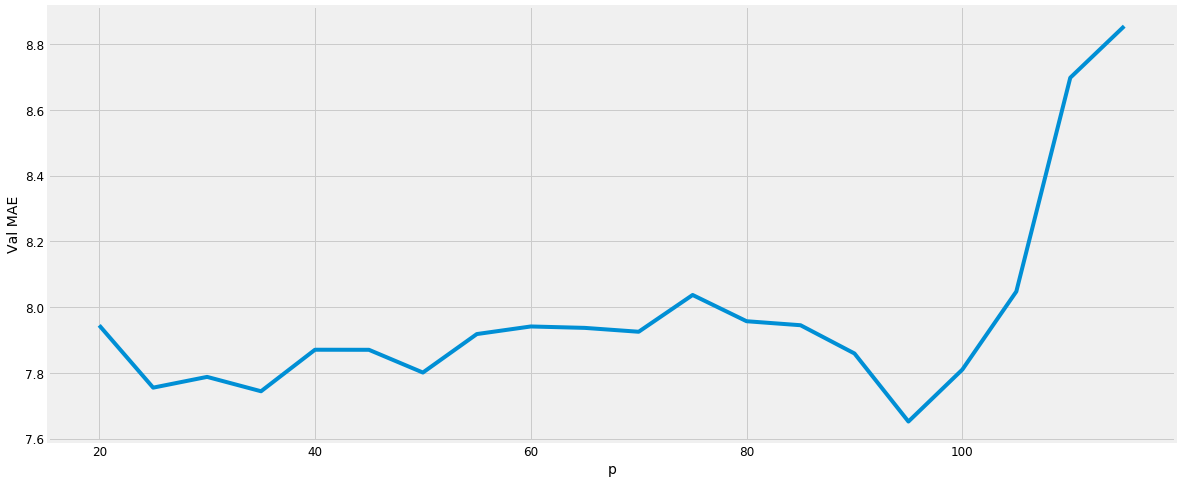

In [20]:
def treat_features(data, lag=1):
    Y = data['total_cases'].values.reshape(-1, 1)
    Y = np.log(1+Y)
    X = [[y[0] for y in Y[i:i+lag].tolist()] for i in range(0, len(Y)-lag)]
    Y = Y[lag:]
    return np.array(X), np.array(Y)


def fit_regression(data_train, data_val, lag):
    linear_regressor = LinearRegression()  # create object for the class

    X, Y = treat_features(data_train, lag=lag)

    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    train_mae = error
#     print("Train MAE = {}".format(error))

    X = [y[0] for y in Y[-lag:]]
    Y=[]
    for i in range(0, len(data_val)):
        nexty = linear_regressor.predict([X])[0][0]
        Y.append(nexty)
        X = X[1:] + [nexty]

    Y = np.exp(Y)-1
    true = data_val['total_cases'].values
    error = mean_absolute_error(true, Y)
    val_mae = error
#     print("Validation MAE = {}".format(error))
    return [lag, train_mae, val_mae]


a = [fit_regression(sj_train, sj_val, lag=lag) for lag in range(20, 250, 5)]
a = np.array(a).T
print(a[0][a[2].argmin()])
# plt.plot(a[0], a[1])
plt.plot(a[0], a[2])
plt.xlabel("p")
plt.ylabel("Val MAE")
plt.show()

a = [fit_regression(iq_train, iq_val, lag=lag) for lag in range(20, 120, 5)]
a = np.array(a).T
print(a[0][a[2].argmin()])
# plt.plot(a[0], a[1])
plt.plot(a[0], a[2])
plt.xlabel("p")
plt.ylabel("Val MAE")
plt.show()

# val_mae = fit_regression(sj_train, sj_val, lag=200)
# fit_regression(sj_train, sj_val, lag=215)
# fit_regression(iq_train, iq_val, lag=80)

# X, Y = treat_features(sj_val)  # values converts it into a numpy array
# Y_pred = linear_regressor.predict(X)  # make predictions
# error = mean_absolute_error(Y, Y_pred)
# print("Validation MAE = {}".format(error))

# Model without exougenous variables

# Model with exougenous variables

In [7]:
def treat_data(df_train, df_val):
    history = df_train['total_cases']
    history_exogenous = df_train.drop(['index', 'total_cases', 
                                       'city', 'year', 
                                       'week_start_date', 'weekofyear'], 
                                      axis=1)
    history_exogenous.fillna(method='ffill', inplace=True)
    val = df_val['total_cases']
    return history_exogenous

    
a = treat_data(sj_train, sj_val)
a.head(5)


,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
def select_features(data, threshold):
    data = data.drop(['index', 'weekofyear', 'week_start_date', 'year'], axis=1)
    corr = data.corr()["total_cases"].abs().sort_values()
    corr = corr[corr > threshold]
    return corr.index

def time_series_analysis(df_train, df_val, log_ratio=False, normalize=False, features=[], optimizer_kwargs={}):
    history = df_train['total_cases']
    val = df_val['total_cases']
    
#     decomposition = sm.tsa.seasonal_decompose(history, model='additive', freq=52)
#     print(decomposition)
#     fig = decomposition.plot()
    
    history_exogenous=None
    val_exogenous=None
    if len(features)>0:
        history_exogenous = df_train[features].drop('total_cases', axis=1)
        history_exogenous.fillna(method='ffill', inplace=True)
        history_exogenous.fillna(method='bfill', inplace=True)
        
        val_exogenous = df_val[features].drop('total_cases', axis=1)
        val_exogenous.fillna(method='ffill', inplace=True)
        val_exogenous.fillna(method='bfill', inplace=True)
        
        if normalize:
            tmean = history_exogenous.mean()
            tmax = history_exogenous.max()
            tmin = history_exogenous.min()
            history_exogenous = (history_exogenous - tmean) / (tmax - tmin)
            val_exogenous = (val_exogenous - tmean) / (tmax - tmin)
        
    
    if log_ratio:
        history = np.log(1+history)
        val = np.log(1+val)
    
    # Decomposition for visual analysis
    rcParams['figure.figsize'] = 18, 8
    
    # Fit a Sarimax Model with 1 year sasonality (cant get 3 years to work)
    mod = sm.tsa.statespace.SARIMAX(history, exog=history_exogenous, order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 52),
                                    enforce_stationarity=False, enforce_invertibility=False)

    results = mod.fit(**optimizer_kwargs)
    print('AIC:{}'.format(results.aic))
#     print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(18, 8))
#     plt.show()
    
    # Make a prediction for the validation set and compare with ground truth
    pred_uc = results.get_forecast(steps=len(val), exog=val_exogenous)
#     pred_ci = pred_uc.conf_int()
#     ax = val.plot(label='observed', figsize=(14, 4))
#     pred_uc.predicted_mean.plot(label='Forecast')
#     ax.fill_between(pred_ci.index[:],
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=.2)
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Registered Cases')
#     plt.legend()
#     plt.show()

    predictions = pred_uc.predicted_mean.values
    
    if log_ratio:
        history = np.exp(history)-1
        val = np.exp(val) -1
    
    error = mean_absolute_error(val, predictions)
    print('Test MAE: %.3f' % error)

    


In [9]:
optimizer_kwargs = {
    "method": "newton"
}
# optimizer_kwargs = {"maxiter": 1,
#                     "time_varying_regression": True,
#                     "mle_regression": False}
# optimizer_kwargs = {}
# optimizer_kwargs = {}
# optimizer_kwargs = {"maxiter": 1}

In [10]:
features = select_features(iq_train, 0.15)



time_series_analysis(iq_train, iq_val, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, log_ratio=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, normalize=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, log_ratio=True, normalize=True, optimizer_kwargs=optimizer_kwargs)

time_series_analysis(iq_train, iq_val, features=features,
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, normalize=True, 
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, log_ratio=True, 
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, log_ratio=True, normalize=True,
                     optimizer_kwargs=optimizer_kwargs)

KeyboardInterrupt: 

In [ ]:
features = select_features(sj_train, 0.15)



# time_series_analysis(sj_train, sj_val, optimizer_kwargs=optimizer_kwargs)
# time_series_analysis(sj_train, sj_val, normalize=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, log_ratio=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, log_ratio=True, normalize=True, optimizer_kwargs=optimizer_kwargs)

# time_series_analysis(sj_train, sj_val, features=features,
#                      optimizer_kwargs=optimizer_kwargs)
# time_series_analysis(sj_train, sj_val, features=features, normalize=True,
#                      optimizer_kwargs=optimizer_kwargs)
# time_series_analysis(sj_train, sj_val, features=features, log_ratio=True, 
#                      optimizer_kwargs=optimizer_kwargs)
# time_series_analysis(sj_train, sj_val, features=features, log_ratio=True, normalize=True,
#                      optimizer_kwargs=optimizer_kwargs)